# Qubit Mapping

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/middle_level/mindspore_qubit_mapping.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/middle_level/mindspore_qubit_mapping.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/middle_level/qubit_mapping.ipynb)

When designing quantum circuits, users often design them based on their algorithmic requirements. However, current quantum chips often struggle to achieve coupling between all qubits. Therefore, when executing quantum circuits on quantum computing hardware, we need to rearrange the qubits used in the quantum algorithm or add some [SWAP](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.SWAPGate.html) gates to coupe qubits that were originally uncoupled. This is known as qubit mapping algorithm.

In this tutorial, we will first introduce the qubit node object [QubitNode](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.QubitNode.html) and qubit topology object [QubitsTopology](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.QubitsTopology.html). Then, we will explain how to compile quantum circuits using the qubit mapping algorithm.

## Qubit Node

[QubitNode](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.QubitNode.html) represents the qubit in quantum chip. Currently, it has four properties:

- qubit_id: The unique id of quantum qubit.
- color: The face color when drawing qubit, default value is #000000.
- poi_x: The x position when drawing qubit, default value is 0.0
- poi_y: The y position when drawing qubit, default value is 0.0

Here, we are going to initialize a qubit node:

In [1]:
from mindquantum.device import QubitNode

q0 = QubitNode(0, '#121212', 0, 0)

print(f"qubit id: {q0.qubit_id}, with color: {q0.color}, and position ({q0.poi_x}, {q0.poi_y})")

qubit id: 0, with color: #121212, and position (0, 0)


QubitNode can be connected by operator `>>` or `<<`. Also you can disconnect them by `>` or `<`. The different operator for connecting or disconnecting will return different QubitNode.

|lhs|op|rhs|Effect|Return|
| --|--|-- |-- |--|
|q0 |`>>`|q1 |Connect tow qubits|q1|
|q0 |`<<`|q1 |Connect tow qubits|q0|
|q0 |`>`|q1 |Disconnect tow qubits|q1|
|q0 |`<`|q1 |Disconnect tow qubits|q0|

Based on the operation we defined above, we can quickly connect qubits like this:

In [2]:
q0, q1, q2 = QubitNode(0), QubitNode(1), QubitNode(2)

q0 >> q1 >> q2

In the above code, `q0 >> q1` will connect the bits `q0` and `q1`, and return the bit `q1`, and then through `>> q2` you can connect `q1` and `q2`.

### QubitsTopology

The [QubitsTopology](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.QubitsTopology.html) class is a container for qubits, which can effectively organize and manipulate them. For example, when we want to build a one-dimensional chain of qubits, we can do the following:

In [3]:
from mindquantum.device import QubitsTopology, QubitNode

n = 5

topology = QubitsTopology([QubitNode(i, poi_x=i) for i in range(n)])
print(topology)

MindQuantum also provides a method to show the topology:

In [4]:
from mindquantum.io.display import draw_topology

draw_topology(topology)

From above, we successfully generate 5 qubits, but not connected them yet. Now we are going to connect them:

In [5]:
left_node = topology[0]
for i in range(1, n):
    left_node = left_node << topology[i]

draw_topology(topology)

In above code, we get the qubit with its qubit_id with operation `[]`, and connect then with operation `<<`.

In MindQuantum, we already designed some qubit topology, such as [LinearQubits](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.LinearQubits.html) and [GradQubits](https://mindspore.cn/mindquantum/docs/en/master/device/mindquantum.device.GridQubits.html#mindquantum.device.GridQubits):

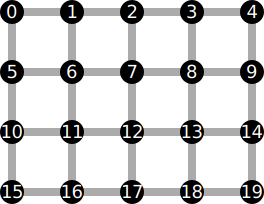

In [6]:
from mindquantum.device import LinearQubits, GridQubits
from IPython.display import display_svg

t1 = LinearQubits(3)
t2 = GridQubits(4, 5)

display_svg(draw_topology(t1))
display_svg(draw_topology(t2))

We can also perform more operations on qubit topology, such as delete som qubit node:

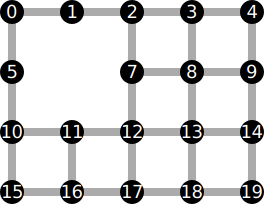

In [7]:
t2.remove_qubit_node(6)

draw_topology(t2)

isolate some qubit node:

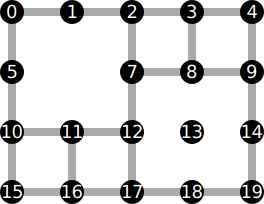

In [8]:
t2.isolate_with_near(13)

draw_topology(t2)

change the color of some qubit note:

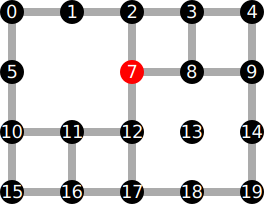

In [9]:
t2.set_color(7, '#ff0000')

draw_topology(t2)

change the position of some qubit node:

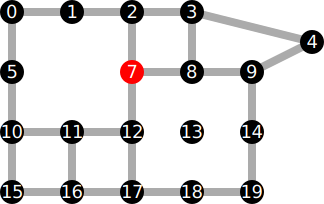

In [10]:
t2.set_position(4, 5.0, 0.5)

draw_topology(t2)

or re-coupling with other qubit node:

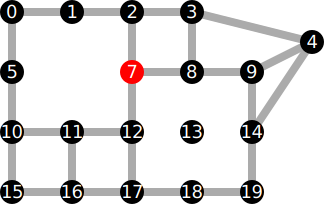

In [11]:
t2[4] << t2[14]

draw_topology(t2)

We can also get all coupled edges of the qubit topology:

In [12]:
t2.edges_with_id()

{(0, 1),
 (0, 5),
 (1, 2),
 (2, 3),
 (2, 7),
 (3, 4),
 (3, 8),
 (4, 9),
 (4, 14),
 (5, 10),
 (7, 8),
 (7, 12),
 (8, 9),
 (9, 14),
 (10, 11),
 (10, 15),
 (11, 12),
 (11, 16),
 (12, 17),
 (14, 19),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19)}

### Qubit Mapping

When we run quantum circuits on real quantum hardware, we often cannot run them directly, because the qubit topology in the real hardware and the quantum circuit structure given by the user may not match. Then qubit mapping technology comes in. We can remap the quantum bits or insert some [SWAP](https://mindspore.cn/mindquantum/docs/en/master/core/mindquantum.core.gates.html#pre-instantiated-gate) gates to make the circuit run successfully.

We give a quantum circuit:

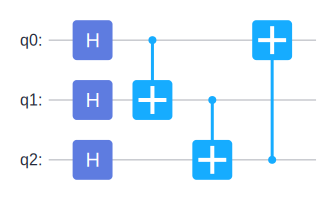

In [13]:
from mindquantum.core.circuit import Circuit

circ = Circuit().h(0).h(1).h(2).x(1, 0).x(2, 1).x(0, 2)
circ.svg()

following a 2x2 grid qubit topology:

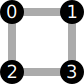

In [14]:
t = GridQubits(2, 2)

draw_topology(t)

Because the qubits in the above quantum circuit have interactions with each other, it cannot be directly run on the above quantum hardware. We introduce the [SABER](https://mindspore.cn/mindquantum/docs/en/master/algorithm/mapping/mindquantum.algorithm.mapping.SABRE.html#mindquantum.algorithm.mapping.SABRE) algorithm to solve this problem. For more algorithm details, please refer to the paper: [Tackling the Qubit Mapping Problem for NISQ-Era Quantum Devices](https://arxiv.org/abs/1809.02573).

In [15]:
from mindquantum.algorithm.mapping import SABRE

solver = SABRE(circ, t)
new_circ, init_mapping, final_mapping = solver.solve(5, 0.5, 0.3, 0.2)

The new quantum circuit after compiling is:

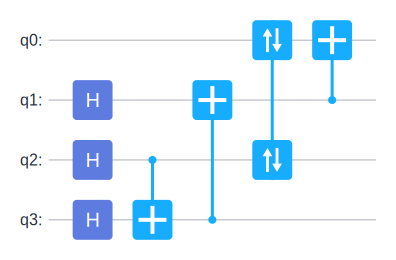

In [16]:
new_circ.svg()

By comparing the old quantum circuit, we know that the algorithm reassigns the qubit id and inserts [SWAP](https://mindspore.cn/mindquantum/docs/en/master/core/mindquantum.core.gates.html#pre-instantiated-gate) gates at appropriate positions, making the circuit run normally.

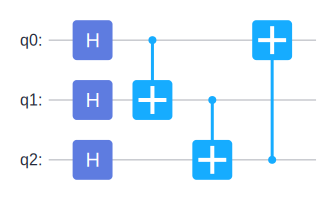

In [17]:
circ.svg()

Here `init_mapping` and `final_mapping` tells us how to run the circuit at very begin and what is the relationship with the origin qubit id and final qubit id after running the circuit.

In [18]:
print(f"initial mapping: {init_mapping}")
print(f"  final mapping: {final_mapping}")

initial mapping: [2, 3, 1, 0]
  final mapping: [0, 3, 1, 2]


We can also use `draw_topology` to show which edges will be used when running the compiled circuit.

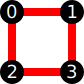

In [19]:
draw_topology(t, new_circ)

From the above result, all four edges in qubit topology are all used.

In [20]:
from mindquantum.utils.show_info import InfoTable
InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.24.4
System,Info
Python,3.8.17
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Jan 2 16:53:03 2024
